In [3]:
# This is the main code of project 1 

# SECTION 1
# Parsing the hh.kz website and saving the data into excel file

import re
from selenium import webdriver
from selenium.webdriver.common.by import By
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
driver = webdriver.Chrome()
base_url = "https://almaty.hh.kz/search/vacancy?L_save_area=true&text=&excluded_text=&professional_role=156&professional_role=160&professional_role=150&professional_role=25&professional_role=165&professional_role=36&professional_role=96&professional_role=104&professional_role=157&professional_role=112&professional_role=113&professional_role=148&professional_role=114&professional_role=116&professional_role=121&professional_role=124&professional_role=125&area=160&salary=&currency_code=KZT&experience=doesNotMatter&order_by=relevance&search_period=0&items_on_page=50&hhtmFrom=vacancy_search_filter&page="

In [ ]:
# Scrape job listings across multiple pages, extracting details like title, 
# company, experience, salary, and requirements, and store them in a list.

current_page = 1
jobs = []

while True:
    # Construct the URL for the current page
    url = f"{base_url}{current_page}"
    driver.get(url)
    time.sleep(5)

    # Scroll down to ensure all elements are loaded
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5)

    # Extract job data using Selenium for consistency
    vacancies = driver.find_elements(By.CSS_SELECTOR, "div.vacancy-info--umZA61PpMY07JVJtomBA")
    if not vacancies:  # Stop if no more vacancies are found
        break

    for vacancy in vacancies:
        try:
            # Extract the job title
            try:
                title_element = vacancy.find_element(By.CSS_SELECTOR, "a[data-qa='serp-item__title']")
                title = title_element.text.strip()
                link = title_element.get_attribute('href')
            except:
                title = 'Not specified'
                link = 'Not specified'

            # Extract the company name
            try:
                company_element = vacancy.find_element(By.CSS_SELECTOR, "a[data-qa='vacancy-serp__vacancy-employer']")
                company = company_element.text.strip()
            except:
                company = 'Not specified'

            # Extract experience information
            try:
                experience_element = vacancy.find_element(By.CLASS_NAME, "magritte-tag__label___YHV-o_3-0-13").get_attribute("innerHTML")
            except:
                experience_element = 'Not specified'

            # Extract salary information
            try:
                salary = vacancy.find_element(By.CSS_SELECTOR, "span.magritte-text___pbpft_3-0-15.magritte-text_style-primary___AQ7MW_3-0-15.magritte-text_typography-label-1-regular___pi3R-_3-0-15").text
            except:
                salary = 'Not specified'

            # Extract requirement information
            try:
                requirement_element = vacancy.find_element(By.CSS_SELECTOR, "div[data-qa='vacancy-serp__vacancy_snippet_requirement'] > span").text.strip()
            except:
                requirement_element = 'Not specified'

            # Append the job information
            jobs.append({
                'Job Title': title,
                'Company': company,
                #'Location': location,
                'Experience': experience_element,
                'Salary': salary,
                'Requirements': requirement_element,
                'Link': link
            })

        except Exception as e:
            print(f"Error while extracting data for a job: {e}")

    current_page += 1

driver.quit()

In [ ]:
# Convert to DataFrame and save as Excel

df = pd.DataFrame(jobs)
print(df)
df.to_excel('job_listings_all_pages.xlsx', index=False)

In [4]:
# SECTION 2
# Research question 1:
# What is the most popular specialization among junior-level developer vacancies?

# Create a DataFrame consisting only of titles and salaries of vacancies

df = pd.read_excel('job_listings_all_pages.xlsx')
df_work = df[['Job Title', 'Salary']]
#df_work.to_excel('titles_and_salary.xlsx', index = False)

In [5]:
df_work.loc[:, 'Job Title'] = df_work['Job Title'].str.lower()
df_work = df_work.dropna(subset=['Job Title'])

In [6]:
# Select raws that contain words "junior" and "младший"

junior = df_work[df_work['Job Title'].str.contains('junior|младший')]
junior.head()

,Job Title,Salary
9,младший специалист технической поддержки,Not specified
16,junior cyber security engineer,350 000 – 500 000 ₸ на руки
32,младший it специалист,Not specified
41,junior frontend developer,от 300 000 ₸ на руки
42,junior python rpa developer,от 150 000 ₸ на руки


In [7]:
junior = junior.reset_index(drop=True)
junior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Job Title  26 non-null     object
 1   Salary     26 non-null     object
dtypes: object(2)
memory usage: 544.0+ bytes


In [8]:
# Create a dictionary of key words that target professions

result_dic = {
    "Helpdesk": ["специалист", "specialist", "поддержки", "l1", "product"],
    "Cybersecurity": ["cyber"],
    "Front end": ["frontend"],
    "Python": ["python"],
    "Analyst": ["analyst", "аналитик", "sales"],
    "Back end": ["backend"],
    "DevOps": ["devops"],
    "Tester": ["qa-engineer", "тестировщик"],
    ".NET developer": [".net"],
    "AI developer": ["ai"],
    "1C developer": ["1с"],
    "Full stack": ["full"]
}
result_dic

{'Helpdesk': ['специалист', 'specialist', 'поддержки', 'l1', 'product'],
 'Cybersecurity': ['cyber'],
 'Front end': ['frontend'],
 'Python': ['python'],
 'Analyst': ['analyst', 'аналитик', 'sales'],
 'Back end': ['backend'],
 'DevOps': ['devops'],
 'Tester': ['qa-engineer', 'тестировщик'],
 '.NET developer': ['.net'],
 'AI developer': ['ai'],
 '1C developer': ['1с'],
 'Full stack': ['full']}

In [9]:
# Get series by applying a function that normalizes job titles

# Function that merges different descriptions of the same profession into one
def normalize_title(title):
    for profession, keywords in result_dic.items():
        if any(keyword in title for keyword in keywords):
            return profession
            
jobs = junior['Job Title'].apply(normalize_title)
jobs

0           Helpdesk
1      Cybersecurity
2           Helpdesk
3          Front end
4             Python
5            Analyst
6           Back end
7             DevOps
8             Tester
9           Helpdesk
10    .NET developer
11      AI developer
12          Helpdesk
13          Helpdesk
14          Helpdesk
15           Analyst
16          Helpdesk
17          Helpdesk
18    .NET developer
19           Analyst
20      1C developer
21         Front end
22         Front end
23           Analyst
24        Full stack
25            Tester
Name: Job Title, dtype: object

In [10]:
# Count occurrences of each IT profession and display the result

profession_count = jobs.value_counts()
print(profession_count)

Job Title
Helpdesk          8
Analyst           4
Front end         3
Tester            2
.NET developer    2
Cybersecurity     1
Python            1
Back end          1
DevOps            1
AI developer      1
1C developer      1
Full stack        1
Name: count, dtype: int64


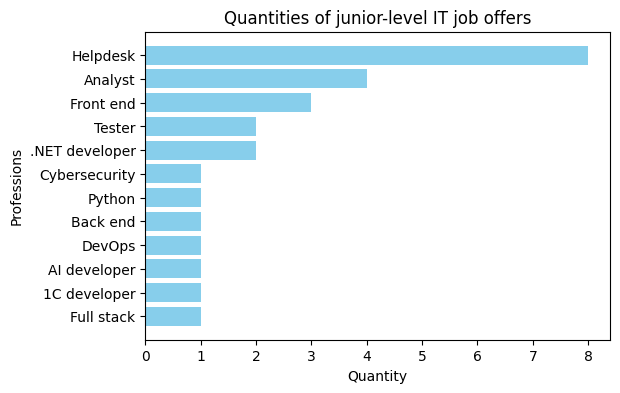

In [11]:
# Create a graph of quantites of IT professions

proffesion_count = profession_count.sort_values(ascending=False)

plt.figure(figsize=(6, 4)) 
plt.barh(profession_count.index, profession_count.values, color='skyblue')
plt.xlabel('Quantity')
plt.ylabel('Professions')
plt.title('Quantities of junior-level IT job offers')
plt.gca().invert_yaxis()
plt.show()

In [12]:
junior_with_salaries = junior[junior['Salary'] != 'Not specified']
junior_with_salaries = junior_with_salaries.reset_index(drop=True)
junior_with_salaries

,Job Title,Salary
0,junior cyber security engineer,350 000 – 500 000 ₸ на руки
1,junior frontend developer,от 300 000 ₸ на руки
2,junior python rpa developer,от 150 000 ₸ на руки
3,junior backend go разработчик,от 200 000 ₸ на руки
4,junior devops engineer,200 000 – 400 000 ₸ на руки
5,junior ai developer,400 – 600 $ на руки
6,junior product manager,150 000 – 250 000 ₸ на руки
7,business/system analyst (junior-middle),от 500 000 ₸ до вычета налогов
8,junior frontend developer (react),50 000 – 150 000 ₸ на руки
9,junior frontend разработчик,до 500 $ до вычета налогов


In [14]:
# SECTION 3
# Research question 2:
# Which company is hiring the most, and what levels of specialization are they hiring?

# Count vacancies in each company to get the most hiring one.

df = pd.read_excel('job_listings_all_pages.xlsx')
count_c = df['Company'].value_counts(dropna=False)
print(count_c)

Company
АО Народный банк Казахстана                        40
АО Kcell                                           31
Beeline, ТМ                                        30
Публичная Компания «Freedom Finance Global PLC»    26
ТОО Неткрэкер Текнолоджи Казахстан                 17
                                                   ..
ТОО Талисман качества                               1
ТОО ИНТЕРКОМП КАЗАХСТАН                             1
ТОО Inter Service (Интер Сервис)                    1
Фонд Общественный фонд «NNEF»                       1
ЧК WHITE HILL CAPITAL LTD.                          1
Name: count, Length: 580, dtype: int64


In [16]:
# Save vacancies of the most hiring company to new DF and refine it

mh_company = df[df['Company']=='АО Народный банк Казахстана'].copy()
mh_company.loc[mh_company['Experience']=='Опыт более 6&nbsp;лет', 'Experience'] = 'Опыт более 6 лет'
experience = mh_company['Experience'].unique().tolist()

In [17]:
# Count how many vacancies are there for each experience level

count_level = mh_company['Experience'].value_counts(dropna=False)
results = [count_c.head(1), count_level]
results

[Company
 АО Народный банк Казахстана    40
 Name: count, dtype: int64,
 Experience
 Опыт 1-3 года       19
 Опыт 3-6 лет        18
 Без опыта            2
 Опыт более 6 лет     1
 Name: count, dtype: int64]

In [22]:
# SECTION 4
# Research question 3:
# How can parsing IT job listings from Headhunter.kz reveal insights into the most 
# in-demand skills and technologies in Kazakhstan's tech industry?

# Load the dataset from the provided file

file_path = 'job_listings_all_pages.xlsx'
df = pd.read_excel(file_path)
df.head()

,Job Title,Company,Experience,Salary,Requirements,Link
0,Business Intelligence аналитик,"AIR ASTANA, АО",Опыт 1-3 года,Not specified,Not specified,https://almaty.hh.kz/vacancy/108773136?hhtmFro...
1,Аналитик данных,ТОО Новатор Фарма,Без опыта,150 000 – 350 000 ₸ до вычета налогов,Not specified,https://almaty.hh.kz/vacancy/108099723?hhtmFro...
2,Системный администратор,ТОО QALANKZ,Без опыта,300 000 – 400 000 ₸ до вычета налогов,Not specified,https://almaty.hh.kz/vacancy/108396151?hhtmFro...
3,Системный администратор,ИП NOVO-e,Опыт 3-6 лет,350 000 – 430 000 ₸ на руки,Not specified,https://almaty.hh.kz/vacancy/108770141?hhtmFro...
4,Technical Support Specialist,ТОО Samsung Electronics Central Eurasia LLP.,Опыт 3-6 лет,Not specified,Not specified,https://almaty.hh.kz/vacancy/108766916?hhtmFro...


In [26]:
# List of programming languages and technologies to look for
languages = [
    'Python', 'Java', 'JavaScript', 'C#', 'PHP', 'Swift', 'Kotlin', 'Go', 'R',
    'Ruby', 'Perl', 'HTML', 'CSS', 'SQL', 'TypeScript', 'Dart', 'Rust', 'Scala',
    'RPA', 'Frontend', 'Backend', 'Full Stack'
]

In [27]:
# Function to categorize job titles based on programming languages
def extract_languages(job_title):
    found_languages = [lang for lang in languages if re.search(fr'\b{lang}\b', job_title, re.IGNORECASE)]
    return ', '.join(found_languages) if found_languages else 'Other'

# Apply the function to create a new column with extracted languages
df['Languages'] = df['Job Title'].apply(extract_languages)

In [28]:
# Count the occurrences of each job title to determine demand

# Count the occurrences of each language/technology to determine demand
language_demand = df['Languages'].value_counts().reset_index()
language_demand.columns = ['Programming Language', 'Demand']  # Rename columns for clarity

# Sort the data in descending order by demand
language_demand = language_demand.sort_values(by='Demand', ascending=False)
language_demand

,Programming Language,Demand
0,Other,954
1,Java,30
2,PHP,30
3,Frontend,29
4,Backend,18
5,Python,13
6,Full Stack,8
7,SQL,6
8,"Java, Backend",5
14,"Python, Backend",4
